<h1><strong>Import Library</strong></h1>

In [1]:
import numpy as np
import pandas as pd
import torch
import os
import shutil
import itertools
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import ConcatDataset, DataLoader, Subset, Dataset, SubsetRandomSampler
from torchvision.datasets import DatasetFolder, VisionDataset
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold

from tqdm.auto import tqdm
import random

In [2]:
myseed = 123456 #just a random number
_exp_name = "sample"
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

<h1><strong>Create Augmentation for the Dataset </strong></h1>

In [3]:
validation_tfm = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor()
    ])

train_tfm = transforms.Compose([
    
    transforms.Resize((128,128)),
    
    transforms.ColorJitter(brightness=0.15, saturation=0.15, contrast=0.15),
    transforms.RandomAffine(degrees=20, translate=(0.15,0.15), scale=(1,1.2)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()    
])

<h1><strong>Dataset Class</strong></h1>

In [4]:
class PinappleDataset(Dataset):
    def __init__(self,path,tfm,files = None):
        super(PinappleDataset).__init__()
        self.path = path #path for the dataset 
        self.files = path
        if files!= None:
            self.files = files
        print(f"One {path} sample", self.files[0])
        self.transform = tfm #transform or the image augmentation
        
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        fname = self.files[idx]
        im = Image.open(fname)
        im = self.transform(im)
        
        label = fname.split("/")[-2]
        
        if label == "stage_501":
            return im, 0
        elif label == "stage_505":
            return im, 1
        elif label == "stage_509":
            return im, 2
        elif label == "stage_601":
            return im, 3
        elif label == "stage_605":
            return im, 4
        elif label == "stage_609":
            return im, 5
        elif label == "stage_701":
            return im, 6
        elif label == "stage_705":
            return im, 7
        elif label == "stage_709":
            return im, 8
        else:
            print(f"{fname}:No Label")

<h1><strong>CNN</strong></h1>

In [5]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # torch.nn.MaxPool2d(kernel_size, stride, padding)
        # input 維度 [3, 128, 128]
#         (128x8192 and 16384x256)
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),  # [64, 128, 128]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [64, 64, 64]

            nn.Conv2d(64, 128, 3, 1, 1), # [128, 64, 64]
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [128, 32, 32]

            nn.Conv2d(128, 256, 3, 1, 1), # [256, 32, 32]
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [256, 16, 16]

            nn.Conv2d(256, 512, 3, 1, 1), # [512, 16, 16]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),       # [512, 8, 8]
            
            nn.Conv2d(512, 512, 3, 1, 1), # [512, 8, 8]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),       # [512, 4, 4]
        )
        self.fc = nn.Sequential(
            nn.Linear(128*8*8, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 9) #We have 9 classes 
        )

    def forward(self, x):
        out = self.cnn(x)
        out = out.view(out.size()[0], -1)
        return self.fc(out)

<h2>Create DataLoader</h2>

In [6]:
batch_size = 128 
_dataset_dir = "Pineapple_image" #dataset path

train_path = "./Dataset/Train" #train directory
valid_path = "./Dataset/Validation" #valid directory

filePath = []

#split the dataset to train and validation
directPath = [x for x in os.listdir(_dataset_dir)] #need to change
for directory in directPath:
    for fileName in os.listdir(os.path.join(_dataset_dir,directory)):
        filePath.append(_dataset_dir + "/"+ directory + "/" + fileName)

train_dataset, validation_dataset = train_test_split(filePath, random_state = 104, test_size = 0.2, shuffle= True)

dataTrain = PinappleDataset(train_dataset, tfm= train_tfm)
dataValid = PinappleDataset(validation_dataset, tfm= validation_tfm)

dataset = ConcatDataset([dataTrain,dataValid])

One ['Pineapple_image/stage_605/DSC_0147.JPG', 'Pineapple_image/stage_709/IMG_4530.JPG', 'Pineapple_image/stage_601/IMG_0551.JPG', 'Pineapple_image/stage_501/IMG_8869.JPG', 'Pineapple_image/stage_505/IMG_20210112_120437.jpg', 'Pineapple_image/stage_501/IMG_3927.JPG', 'Pineapple_image/stage_501/DSC_0507.JPG', 'Pineapple_image/stage_709/IMG_9667.JPG', 'Pineapple_image/stage_509/IMG_0254.JPG', 'Pineapple_image/stage_505/IMG_4472.JPG', 'Pineapple_image/stage_501/IMG_3779.JPG', 'Pineapple_image/stage_705/IMG_9486.JPG', 'Pineapple_image/stage_609/IMG_2777.JPG', 'Pineapple_image/stage_601/IMG_3521.JPG', 'Pineapple_image/stage_609/IMG_5938.JPG', 'Pineapple_image/stage_705/IMG_1315.JPG', 'Pineapple_image/stage_509/IMG_3468.JPG', 'Pineapple_image/stage_509/IMG_0613.JPG', 'Pineapple_image/stage_601/IMG_5616.JPG', 'Pineapple_image/stage_501/IMG_7245.JPG', 'Pineapple_image/stage_705/IMG_0345.JPG', 'Pineapple_image/stage_501/IMG_2082.JPG', 'Pineapple_image/stage_509/IMG_0509.JPG', 'Pineapple_image/s

<h1><strong>Training Loop</strong></h1>

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"

n_epochs = 100
patience = 10 #if no imporvement early stop

model = Classifier().to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr = 0.0003, weight_decay= 1e-5)

stale = 0
best_acc = 0

k = 5
splits = KFold(n_splits= k, shuffle= True, random_state= 42)
trainAcc = []
validAcc = []
totalEpoch = 0
for fold, (train_idx, val_idx) in enumerate(splits.split(np.arange(len(dataset)))):
    train_sampler = SubsetRandomSampler(train_idx)
    val_sampler = SubsetRandomSampler(val_idx)
    
    train_loader = DataLoader(dataset, batch_size = batch_size, sampler = train_sampler)
    val_loader = DataLoader(dataset, batch_size = batch_size, sampler = val_sampler)
    
    for epoch in range(n_epochs):
        totalEpoch +=1
        model.train()
        
        train_loss = []
        train_acs = []
        
        for batch in tqdm(train_loader):
            
            imgs, labels = batch
            
            logits = model(imgs.to(device))
            
            loss = criterion(logits, labels.to(device))
            
            optimizer.zero_grad()
            loss.backward()
            
            grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm= 10)
            
            optimizer.step()
            
            acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()
            
            train_loss.append(loss.item())
            train_acs.append(acc)
            
        train_loss = sum(train_loss) / len(train_loss)
        train_acc = sum(train_acs) / len(train_acs)
        trainAcc.append(train_acc)
        
        
         # Print the information.
        print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")

        # ---------- Validation ----------
        # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
        model.eval()

        # These are used to record information in validation.
        valid_loss = []
        valid_accs = []
        
        for batch in tqdm(val_loader):
            
            imgs, labels = batch
            
            with torch.no_grad():
                logits = model(imgs.to(device))

            loss = criterion(logits, labels.to(device))
    
            acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

            valid_loss.append(loss.item())
            valid_accs.append(acc)
            
        # The average loss and accuracy for entire validation set is the average of the recorded values.
        valid_loss = sum(valid_loss) / len(valid_loss)
        valid_acc = sum(valid_accs) / len(valid_accs)
        validAcc.append(valid_acc)

        # Print the information.
        print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")
        
        # update logs
        if valid_acc > best_acc:
            with open(f"./{_exp_name}_log.txt","a"):
                print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f} -> best")
        else:
            with open(f"./{_exp_name}_log.txt","a"):
                print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")

        # save models
        if valid_acc > best_acc:
            print(f"Best model found at epoch {epoch}, saving model")
            torch.save(model.state_dict(), f"best.pt") # only save best to prevent output memory exceed error
            best_acc = valid_acc
            stale = 0
        else:
            stale += 1
            if stale > patience:
                print(f"No improvment {patience} consecutive epochs, early stopping")
                break
            

  0%|          | 0/12 [00:00<?, ?it/s]

[ Train | 001/100 ] loss = 1.51630, acc = 0.45508


  0%|          | 0/3 [00:00<?, ?it/s]

[ Valid | 001/100 ] loss = 2.68009, acc = 0.13722
[ Valid | 001/100 ] loss = 2.68009, acc = 0.13722 -> best
Best model found at epoch 0, saving model


  0%|          | 0/12 [00:00<?, ?it/s]

[ Train | 002/100 ] loss = 0.89106, acc = 0.65885


  0%|          | 0/3 [00:00<?, ?it/s]

[ Valid | 002/100 ] loss = 3.20319, acc = 0.29527
[ Valid | 002/100 ] loss = 3.20319, acc = 0.29527 -> best
Best model found at epoch 1, saving model


  0%|          | 0/12 [00:00<?, ?it/s]

[ Train | 003/100 ] loss = 0.66470, acc = 0.76367


  0%|          | 0/3 [00:00<?, ?it/s]

[ Valid | 003/100 ] loss = 4.39262, acc = 0.29607
[ Valid | 003/100 ] loss = 4.39262, acc = 0.29607 -> best
Best model found at epoch 2, saving model


  0%|          | 0/12 [00:00<?, ?it/s]

[ Train | 004/100 ] loss = 0.62789, acc = 0.76693


  0%|          | 0/3 [00:00<?, ?it/s]

[ Valid | 004/100 ] loss = 2.42500, acc = 0.34515
[ Valid | 004/100 ] loss = 2.42500, acc = 0.34515 -> best
Best model found at epoch 3, saving model


  0%|          | 0/12 [00:00<?, ?it/s]

[ Train | 005/100 ] loss = 0.47639, acc = 0.81836


  0%|          | 0/3 [00:00<?, ?it/s]

[ Valid | 005/100 ] loss = 1.66401, acc = 0.49499
[ Valid | 005/100 ] loss = 1.66401, acc = 0.49499 -> best
Best model found at epoch 4, saving model


  0%|          | 0/12 [00:00<?, ?it/s]

[ Train | 006/100 ] loss = 0.45778, acc = 0.83529


  0%|          | 0/3 [00:00<?, ?it/s]

[ Valid | 006/100 ] loss = 0.63148, acc = 0.77143
[ Valid | 006/100 ] loss = 0.63148, acc = 0.77143 -> best
Best model found at epoch 5, saving model


  0%|          | 0/12 [00:00<?, ?it/s]

[ Train | 007/100 ] loss = 0.46031, acc = 0.83854


  0%|          | 0/3 [00:00<?, ?it/s]

[ Valid | 007/100 ] loss = 0.58123, acc = 0.79026
[ Valid | 007/100 ] loss = 0.58123, acc = 0.79026 -> best
Best model found at epoch 6, saving model


  0%|          | 0/12 [00:00<?, ?it/s]

[ Train | 008/100 ] loss = 0.42410, acc = 0.84570


  0%|          | 0/3 [00:00<?, ?it/s]

[ Valid | 008/100 ] loss = 0.77522, acc = 0.74359
[ Valid | 008/100 ] loss = 0.77522, acc = 0.74359


  0%|          | 0/12 [00:00<?, ?it/s]

[ Train | 009/100 ] loss = 0.42987, acc = 0.83854


  0%|          | 0/3 [00:00<?, ?it/s]

[ Valid | 009/100 ] loss = 0.47965, acc = 0.84395
[ Valid | 009/100 ] loss = 0.47965, acc = 0.84395 -> best
Best model found at epoch 8, saving model


  0%|          | 0/12 [00:00<?, ?it/s]

[ Train | 010/100 ] loss = 0.33783, acc = 0.87956


  0%|          | 0/3 [00:00<?, ?it/s]

[ Valid | 010/100 ] loss = 0.75856, acc = 0.74439
[ Valid | 010/100 ] loss = 0.75856, acc = 0.74439


  0%|          | 0/12 [00:00<?, ?it/s]

[ Train | 011/100 ] loss = 0.34181, acc = 0.88021


  0%|          | 0/3 [00:00<?, ?it/s]

[ Valid | 011/100 ] loss = 0.57895, acc = 0.79808
[ Valid | 011/100 ] loss = 0.57895, acc = 0.79808


  0%|          | 0/12 [00:00<?, ?it/s]

[ Train | 012/100 ] loss = 0.36569, acc = 0.88281


  0%|          | 0/3 [00:00<?, ?it/s]

[ Valid | 012/100 ] loss = 0.69064, acc = 0.77965
[ Valid | 012/100 ] loss = 0.69064, acc = 0.77965


  0%|          | 0/12 [00:00<?, ?it/s]

[ Train | 013/100 ] loss = 0.29478, acc = 0.89909


  0%|          | 0/3 [00:00<?, ?it/s]

[ Valid | 013/100 ] loss = 0.47572, acc = 0.79988
[ Valid | 013/100 ] loss = 0.47572, acc = 0.79988


  0%|          | 0/12 [00:00<?, ?it/s]

[ Train | 014/100 ] loss = 0.26895, acc = 0.90690


  0%|          | 0/3 [00:00<?, ?it/s]

[ Valid | 014/100 ] loss = 0.70582, acc = 0.75841
[ Valid | 014/100 ] loss = 0.70582, acc = 0.75841


  0%|          | 0/12 [00:00<?, ?it/s]

[ Train | 015/100 ] loss = 0.30432, acc = 0.89714


  0%|          | 0/3 [00:00<?, ?it/s]

[ Valid | 015/100 ] loss = 0.47709, acc = 0.83433
[ Valid | 015/100 ] loss = 0.47709, acc = 0.83433


  0%|          | 0/12 [00:00<?, ?it/s]

[ Train | 016/100 ] loss = 0.25131, acc = 0.90690


  0%|          | 0/3 [00:00<?, ?it/s]

[ Valid | 016/100 ] loss = 0.53777, acc = 0.79067
[ Valid | 016/100 ] loss = 0.53777, acc = 0.79067


  0%|          | 0/12 [00:00<?, ?it/s]

[ Train | 017/100 ] loss = 0.25267, acc = 0.91471


  0%|          | 0/3 [00:00<?, ?it/s]

[ Valid | 017/100 ] loss = 0.64064, acc = 0.81270
[ Valid | 017/100 ] loss = 0.64064, acc = 0.81270


  0%|          | 0/12 [00:00<?, ?it/s]

[ Train | 018/100 ] loss = 0.26297, acc = 0.91016


  0%|          | 0/3 [00:00<?, ?it/s]

[ Valid | 018/100 ] loss = 0.40473, acc = 0.86138
[ Valid | 018/100 ] loss = 0.40473, acc = 0.86138 -> best
Best model found at epoch 17, saving model


  0%|          | 0/12 [00:00<?, ?it/s]

[ Train | 019/100 ] loss = 0.25672, acc = 0.91862


  0%|          | 0/3 [00:00<?, ?it/s]

[ Valid | 019/100 ] loss = 0.43923, acc = 0.83013
[ Valid | 019/100 ] loss = 0.43923, acc = 0.83013


  0%|          | 0/12 [00:00<?, ?it/s]

[ Train | 020/100 ] loss = 0.26749, acc = 0.90299


  0%|          | 0/3 [00:00<?, ?it/s]

[ Valid | 020/100 ] loss = 0.60851, acc = 0.79768
[ Valid | 020/100 ] loss = 0.60851, acc = 0.79768


  0%|          | 0/12 [00:00<?, ?it/s]

[ Train | 021/100 ] loss = 0.28064, acc = 0.89779


  0%|          | 0/3 [00:00<?, ?it/s]

[ Valid | 021/100 ] loss = 0.71757, acc = 0.75060
[ Valid | 021/100 ] loss = 0.71757, acc = 0.75060


  0%|          | 0/12 [00:00<?, ?it/s]

[ Train | 022/100 ] loss = 0.21337, acc = 0.92839


  0%|          | 0/3 [00:00<?, ?it/s]

[ Valid | 022/100 ] loss = 0.65684, acc = 0.80188
[ Valid | 022/100 ] loss = 0.65684, acc = 0.80188


  0%|          | 0/12 [00:00<?, ?it/s]

[ Train | 023/100 ] loss = 0.21590, acc = 0.92253


  0%|          | 0/3 [00:00<?, ?it/s]

[ Valid | 023/100 ] loss = 0.85428, acc = 0.73137
[ Valid | 023/100 ] loss = 0.85428, acc = 0.73137


  0%|          | 0/12 [00:00<?, ?it/s]

[ Train | 024/100 ] loss = 0.18408, acc = 0.93620


  0%|          | 0/3 [00:00<?, ?it/s]

[ Valid | 024/100 ] loss = 0.45433, acc = 0.84655
[ Valid | 024/100 ] loss = 0.45433, acc = 0.84655


  0%|          | 0/12 [00:00<?, ?it/s]

[ Train | 025/100 ] loss = 0.20119, acc = 0.92708


  0%|          | 0/3 [00:00<?, ?it/s]

[ Valid | 025/100 ] loss = 0.83680, acc = 0.76823
[ Valid | 025/100 ] loss = 0.83680, acc = 0.76823


  0%|          | 0/12 [00:00<?, ?it/s]

[ Train | 026/100 ] loss = 0.18898, acc = 0.93620


  0%|          | 0/3 [00:00<?, ?it/s]

[ Valid | 026/100 ] loss = 1.65103, acc = 0.60897
[ Valid | 026/100 ] loss = 1.65103, acc = 0.60897


  0%|          | 0/12 [00:00<?, ?it/s]

[ Train | 027/100 ] loss = 0.22739, acc = 0.91992


  0%|          | 0/3 [00:00<?, ?it/s]

[ Valid | 027/100 ] loss = 0.72281, acc = 0.76242
[ Valid | 027/100 ] loss = 0.72281, acc = 0.76242


  0%|          | 0/12 [00:00<?, ?it/s]

[ Train | 028/100 ] loss = 0.17648, acc = 0.93815


  0%|          | 0/3 [00:00<?, ?it/s]

[ Valid | 028/100 ] loss = 0.59701, acc = 0.83514
[ Valid | 028/100 ] loss = 0.59701, acc = 0.83514


  0%|          | 0/12 [00:00<?, ?it/s]

[ Train | 029/100 ] loss = 0.17284, acc = 0.94010


  0%|          | 0/3 [00:00<?, ?it/s]

[ Valid | 029/100 ] loss = 0.53662, acc = 0.83093
[ Valid | 029/100 ] loss = 0.53662, acc = 0.83093
No improvment 10 consecutive epochs, early stopping


  0%|          | 0/12 [00:00<?, ?it/s]

[ Train | 001/100 ] loss = 0.19308, acc = 0.92578


  0%|          | 0/3 [00:00<?, ?it/s]

[ Valid | 001/100 ] loss = 0.61304, acc = 0.81470
[ Valid | 001/100 ] loss = 0.61304, acc = 0.81470
No improvment 10 consecutive epochs, early stopping


  0%|          | 0/12 [00:00<?, ?it/s]

[ Train | 001/100 ] loss = 0.24973, acc = 0.92253


  0%|          | 0/3 [00:00<?, ?it/s]

[ Valid | 001/100 ] loss = 0.31108, acc = 0.87740
[ Valid | 001/100 ] loss = 0.31108, acc = 0.87740 -> best
Best model found at epoch 0, saving model


  0%|          | 0/12 [00:00<?, ?it/s]

[ Train | 002/100 ] loss = 0.22415, acc = 0.91536


  0%|          | 0/3 [00:00<?, ?it/s]

[ Valid | 002/100 ] loss = 0.78028, acc = 0.76603
[ Valid | 002/100 ] loss = 0.78028, acc = 0.76603


  0%|          | 0/12 [00:00<?, ?it/s]

[ Train | 003/100 ] loss = 0.22817, acc = 0.92513


  0%|          | 0/3 [00:00<?, ?it/s]

[ Valid | 003/100 ] loss = 0.37230, acc = 0.89724
[ Valid | 003/100 ] loss = 0.37230, acc = 0.89724 -> best
Best model found at epoch 2, saving model


  0%|          | 0/12 [00:00<?, ?it/s]

[ Train | 004/100 ] loss = 0.17731, acc = 0.93294


  0%|          | 0/3 [00:00<?, ?it/s]

[ Valid | 004/100 ] loss = 0.34583, acc = 0.87580
[ Valid | 004/100 ] loss = 0.34583, acc = 0.87580


  0%|          | 0/12 [00:00<?, ?it/s]

[ Train | 005/100 ] loss = 0.15704, acc = 0.93815


  0%|          | 0/3 [00:00<?, ?it/s]

[ Valid | 005/100 ] loss = 0.83273, acc = 0.76863
[ Valid | 005/100 ] loss = 0.83273, acc = 0.76863


  0%|          | 0/12 [00:00<?, ?it/s]

[ Train | 006/100 ] loss = 0.15224, acc = 0.94466


  0%|          | 0/3 [00:00<?, ?it/s]

[ Valid | 006/100 ] loss = 0.11139, acc = 0.96575
[ Valid | 006/100 ] loss = 0.11139, acc = 0.96575 -> best
Best model found at epoch 5, saving model


  0%|          | 0/12 [00:00<?, ?it/s]

[ Train | 007/100 ] loss = 0.13787, acc = 0.95638


  0%|          | 0/3 [00:00<?, ?it/s]

[ Valid | 007/100 ] loss = 0.18627, acc = 0.93730
[ Valid | 007/100 ] loss = 0.18627, acc = 0.93730


  0%|          | 0/12 [00:00<?, ?it/s]

[ Train | 008/100 ] loss = 0.12303, acc = 0.95703


  0%|          | 0/3 [00:00<?, ?it/s]

[ Valid | 008/100 ] loss = 0.37605, acc = 0.88341
[ Valid | 008/100 ] loss = 0.37605, acc = 0.88341


  0%|          | 0/12 [00:00<?, ?it/s]

[ Train | 009/100 ] loss = 0.26562, acc = 0.91276


  0%|          | 0/3 [00:00<?, ?it/s]

[ Valid | 009/100 ] loss = 0.29187, acc = 0.90785
[ Valid | 009/100 ] loss = 0.29187, acc = 0.90785


  0%|          | 0/12 [00:00<?, ?it/s]

[ Train | 010/100 ] loss = 0.13544, acc = 0.94661


  0%|          | 0/3 [00:00<?, ?it/s]

[ Valid | 010/100 ] loss = 0.42589, acc = 0.86398
[ Valid | 010/100 ] loss = 0.42589, acc = 0.86398


  0%|          | 0/12 [00:00<?, ?it/s]

[ Train | 011/100 ] loss = 0.12098, acc = 0.95964


  0%|          | 0/3 [00:00<?, ?it/s]

[ Valid | 011/100 ] loss = 0.28415, acc = 0.89383
[ Valid | 011/100 ] loss = 0.28415, acc = 0.89383


  0%|          | 0/12 [00:00<?, ?it/s]

[ Train | 012/100 ] loss = 0.16117, acc = 0.93880


  0%|          | 0/3 [00:00<?, ?it/s]

[ Valid | 012/100 ] loss = 0.16509, acc = 0.92608
[ Valid | 012/100 ] loss = 0.16509, acc = 0.92608


  0%|          | 0/12 [00:00<?, ?it/s]

[ Train | 013/100 ] loss = 0.15077, acc = 0.94336


  0%|          | 0/3 [00:00<?, ?it/s]

[ Valid | 013/100 ] loss = 0.66947, acc = 0.80128
[ Valid | 013/100 ] loss = 0.66947, acc = 0.80128


  0%|          | 0/12 [00:00<?, ?it/s]

[ Train | 014/100 ] loss = 0.17362, acc = 0.93815


  0%|          | 0/3 [00:00<?, ?it/s]

[ Valid | 014/100 ] loss = 0.37780, acc = 0.86158
[ Valid | 014/100 ] loss = 0.37780, acc = 0.86158


  0%|          | 0/12 [00:00<?, ?it/s]

[ Train | 015/100 ] loss = 0.13424, acc = 0.95312


  0%|          | 0/3 [00:00<?, ?it/s]

[ Valid | 015/100 ] loss = 0.20882, acc = 0.91847
[ Valid | 015/100 ] loss = 0.20882, acc = 0.91847


  0%|          | 0/12 [00:00<?, ?it/s]

[ Train | 016/100 ] loss = 0.13378, acc = 0.95378


  0%|          | 0/3 [00:00<?, ?it/s]

[ Valid | 016/100 ] loss = 0.25967, acc = 0.90745
[ Valid | 016/100 ] loss = 0.25967, acc = 0.90745


  0%|          | 0/12 [00:00<?, ?it/s]

[ Train | 017/100 ] loss = 0.14500, acc = 0.94466


  0%|          | 0/3 [00:00<?, ?it/s]

[ Valid | 017/100 ] loss = 0.78505, acc = 0.74880
[ Valid | 017/100 ] loss = 0.78505, acc = 0.74880
No improvment 10 consecutive epochs, early stopping


  0%|          | 0/12 [00:00<?, ?it/s]

[ Train | 001/100 ] loss = 0.15930, acc = 0.94466


  0%|          | 0/3 [00:00<?, ?it/s]

[ Valid | 001/100 ] loss = 0.59584, acc = 0.81070
[ Valid | 001/100 ] loss = 0.59584, acc = 0.81070
No improvment 10 consecutive epochs, early stopping


  0%|          | 0/12 [00:00<?, ?it/s]

[ Train | 001/100 ] loss = 0.10823, acc = 0.95768


  0%|          | 0/3 [00:00<?, ?it/s]

[ Valid | 001/100 ] loss = 0.22892, acc = 0.92047
[ Valid | 001/100 ] loss = 0.22892, acc = 0.92047
No improvment 10 consecutive epochs, early stopping


In [8]:
# util functions
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        # print("Normalized confusion matrix")
    else:
      pass
        # print('Confusion matrix, without normalization')

    # print(cm)
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    # plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.colorbar()

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig('confussion-matrix.jpg')

<h1><strong>Load the Trained Weights</strong></h1>

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = Classifier()
model.load_state_dict(torch.load('best.pt', map_location='cpu'))
model.to(device)

model.eval()
preds = []
groundTruth = []

valLoader = DataLoader(dataValid,batch_size)
for batch in tqdm(valLoader):
    imgs, labels = batch
    with torch.no_grad():
        groundTruth.append(labels.squeeze().cpu().numpy())
        logits = model(imgs.to(device))
        pred = logits.argmax(dim=-1).squeeze().cpu().numpy()
    preds.append(pred)
    
groundTruth = np.concatenate(groundTruth)
preds = np.concatenate(preds)

print(f"Ground Truth: {groundTruth}")
print(f"Preds : {preds}")

  0%|          | 0/3 [00:00<?, ?it/s]

Ground Truth: [2 7 2 6 5 2 7 6 0 1 3 5 3 6 2 1 8 0 1 8 3 6 1 3 4 8 6 3 3 4 8 7 5 2 2 0 2
 6 2 8 5 5 1 1 4 2 2 4 7 1 2 1 8 5 2 2 1 4 6 0 3 2 0 3 0 0 4 0 7 1 2 8 4 5
 6 6 0 0 5 7 8 1 1 6 6 5 6 5 5 5 6 2 7 1 5 2 0 5 8 0 6 3 7 0 6 5 8 4 8 5 2
 3 0 4 1 5 5 6 6 4 1 4 2 1 4 3 0 3 0 7 8 6 6 1 0 8 1 8 1 6 1 7 0 4 1 7 6 8
 2 7 2 4 7 3 2 5 8 4 5 4 4 7 0 3 5 8 0 5 4 5 4 1 8 5 0 8 0 5 2 1 5 6 6 8 0
 0 4 5 7 7 5 4 0 4 5 1 4 1 0 4 1 1 2 3 5 6 1 1 7 5 6 0 4 5 3 3 8 0 4 5 3 7
 2 2 8 5 4 5 2 7 0 6 4 7 6 8 7 8 3 8 8 4 4 0 5 4 2 8 3 5 6 4 4 6 8 6 2 7 5
 7 1 8 4 2 5 3 3 6 6 6 6 6 0 6 4 0 7 2 6 5 7 7 6 6 2 6 4 0 7 3 2 0 5 0 0 8
 4 7 7 8 8 4 4 3 3 0 7 1 0 4 3 3 0 2 0 8 4 8 7 7 2 0 2 7 1 7 0 0 6 6 8 0 7
 6 7 1 5 7 7 8 0 3 3 4 7 6 7 3 7 0 0 1 3 1 6 8 3 0 3 5]
Preds : [2 8 2 6 5 2 7 6 0 1 3 5 3 6 2 1 8 0 1 8 3 6 1 3 4 8 6 3 3 4 8 7 5 2 2 0 2
 6 2 8 5 5 1 1 4 2 2 4 7 1 2 1 8 5 2 2 1 4 6 0 3 2 0 3 0 0 4 0 7 1 2 8 4 5
 6 6 0 0 5 7 8 1 1 6 6 5 6 5 5 5 6 2 7 1 5 2 0 5 8 0 6 3 7 0 6 5 8 4 8 5 2
 3 0 4 1 5 5 5 6 4 1 4

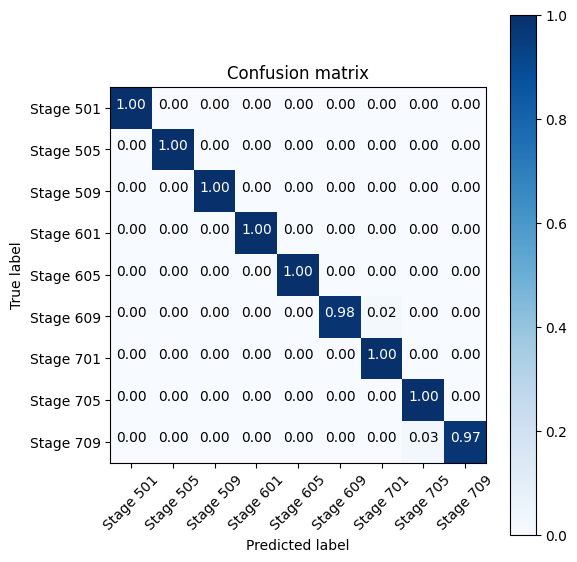

In [10]:
from sklearn.metrics import confusion_matrix

classes = ['Stage 501', 'Stage 505', 'Stage 509', 'Stage 601', 'Stage 605', 'Stage 609', 'Stage 701', 'Stage 705', 'Stage 709']


matrix = confusion_matrix(preds, groundTruth) 
plot_confusion_matrix(matrix, classes=classes, normalize=True)

In [39]:
valid = []
for index,i in enumerate(validAcc):
     valid.append(i.cpu().tolist())
train = []
for index,i in enumerate(trainAcc):
     train.append(i.cpu().tolist())


[0.13721954822540283, 0.29527243971824646, 0.2960737347602844, 0.34515225887298584, 0.4949920177459717, 0.7714343070983887, 0.7902644872665405, 0.7435897588729858, 0.8439503908157349, 0.7443910837173462, 0.7980769872665405, 0.7796474695205688, 0.799879789352417, 0.7584134936332703, 0.8343349695205688, 0.7906650900840759, 0.8127003908157349, 0.8613781929016113, 0.8301281929016113, 0.7976762652397156, 0.7506009936332703, 0.8018831014633179, 0.731370210647583, 0.8465545177459717, 0.7682291865348816, 0.6089743971824646, 0.7624198794364929, 0.8351362943649292, 0.8309295177459717, 0.8147035837173462, 0.8774039149284363, 0.7660256624221802, 0.8972355723381042, 0.8758012652397156, 0.768629789352417, 0.965745210647583, 0.9372997283935547, 0.8834134936332703, 0.9078525900840759, 0.8639823794364929, 0.8938301801681519, 0.9260817766189575, 0.8012821078300476, 0.8615785837173462, 0.9184696078300476, 0.9074519872665405, 0.7487980723381042, 0.810697078704834, 0.9204728007316589]


In [41]:
epoch = np.arange(0,totalEpoch)
print(epoch)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48]


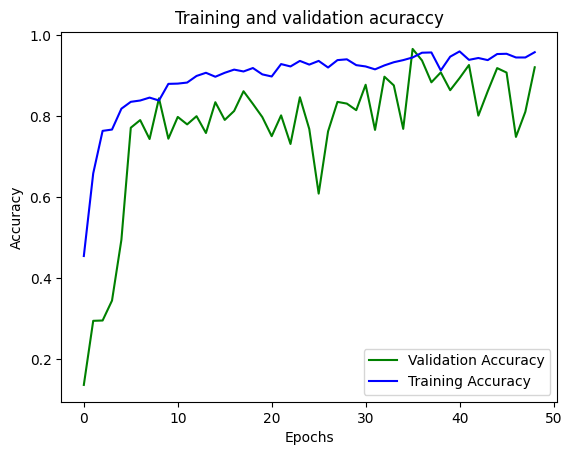

In [43]:
plt.plot(epoch,valid,'g', label = 'Validation Accuracy')
plt.plot(epoch,train,'b', label = 'Training Accuracy')

plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.legend()
plt.show()